In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
adata = sc.read_h5ad("./data/rbc_scanpy_flavor_seurat.h5ad")
adata

AnnData object with n_obs × n_vars = 20521 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden'
    var: 'gene_ids', 'feature_types', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm'
    obsp: 'connectivities', 'distances'

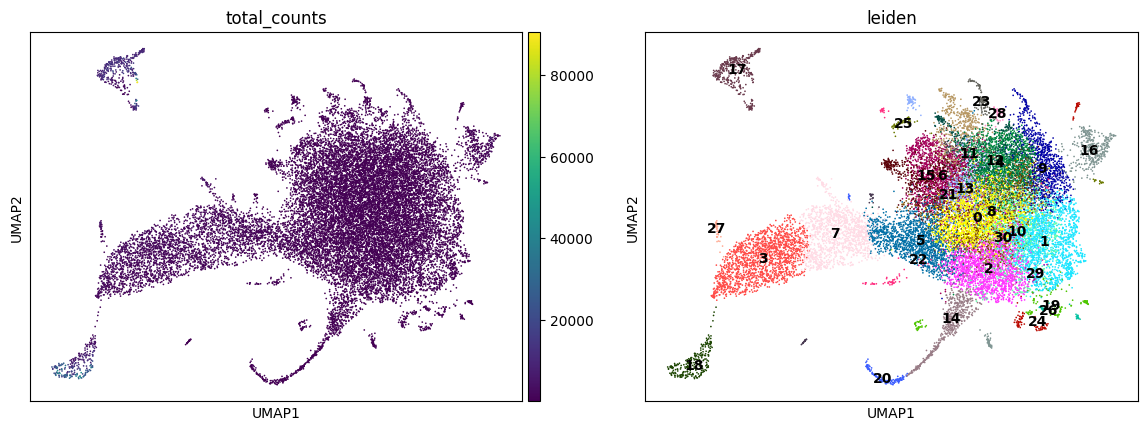

In [3]:
sc.pl.umap(adata,color=['total_counts','leiden'],ncols=2,legend_loc="on data",palette=sc.pl.palettes.default_102)

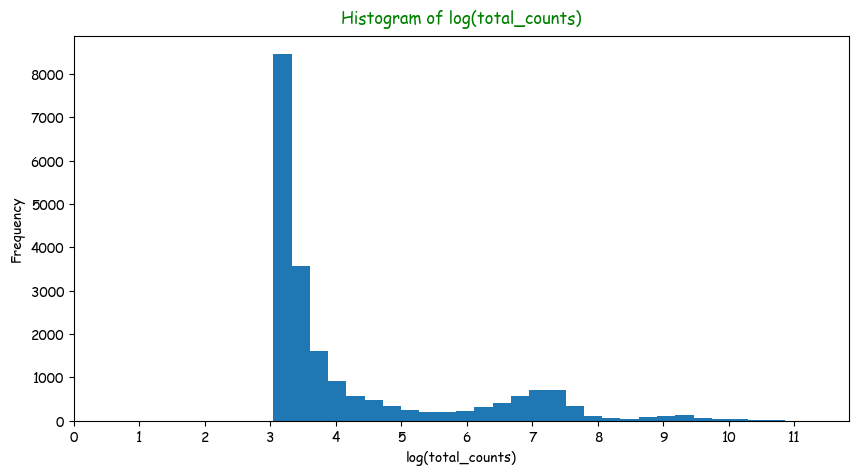

In [5]:
global_settings = {
    "figure.figsize":(10,5),
    "font.family": "Comic Sans MS",
}
with plt.rc_context(global_settings):
    plt.hist(np.log(adata.obs['total_counts']),bins=30)
    plt.title("Histogram of log(total_counts)",y=1.01,color='green')
    plt.ylabel("Frequency")
    plt.xlabel("log(total_counts)")
    plt.xticks(np.arange(0,12,1))
    plt.show()

In [3]:
background_ad = adata[adata.obs["total_counts"].sort_values()[:10000].index]
background_ad

View of AnnData object with n_obs × n_vars = 10000 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'leiden'
    var: 'gene_ids', 'feature_types', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'norm'
    obsp: 'connectivities', 'distances'

In [29]:
background_ad.layers['counts'].sum(axis=0)

matrix([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

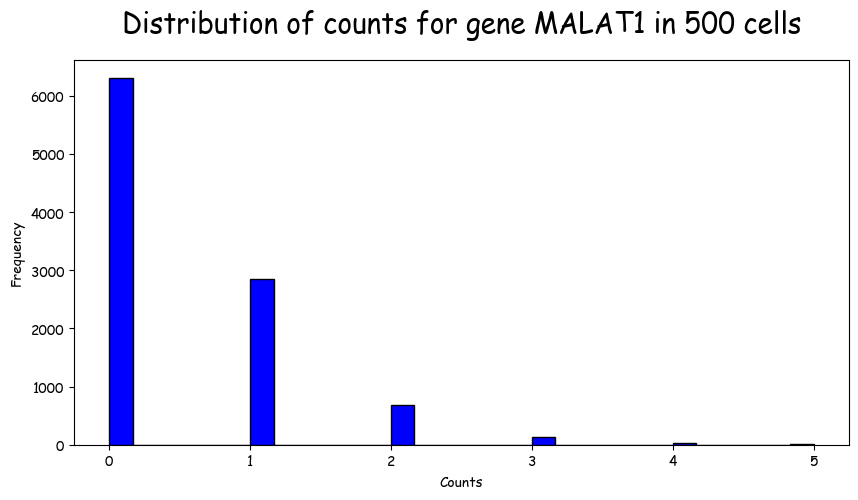

In [6]:
# 获取 counts 数最多的基因名称
max_counts_gene = background_ad.var_names[np.argmax(np.sum(background_ad.layers['counts'], axis=0))]

# 获取该基因在 500 个细胞中的 counts 分布
gene_counts_distribution = background_ad.layers['counts'][:, background_ad.var_names == max_counts_gene].toarray().flatten()

# 绘制直方图
with plt.rc_context(global_settings):
    plt.hist(gene_counts_distribution, bins=30, color='blue', edgecolor='black')
    plt.title(f"Distribution of counts for gene {max_counts_gene} in 500 cells",y=1.05,size=20)
    plt.xlabel("Counts")
    plt.ylabel("Frequency")
    plt.show()

In [10]:
gene_counts_distribution.shape

(10000,)

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm

# 获取 MALAT1 基因的数据
malat1_counts = background_ad.layers['counts'][:, background_ad.var_names == 'MALAT1'].toarray().flatten()

# 拟合 Poisson 分布
poisson_lambda = np.mean(malat1_counts)
poisson_dist = stats.poisson(mu=poisson_lambda)

# 拟合负二项分布
nb_mean = np.mean(malat1_counts)
nb_var = np.var(malat1_counts)
nb_p = nb_mean / nb_var
nb_r = nb_mean * nb_p / (1 - nb_p)
nb_dist = stats.nbinom(n=nb_r, p=nb_p)


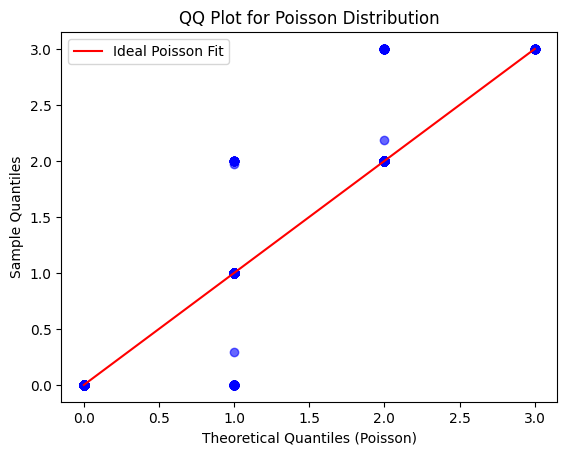

In [38]:
# 计算 Poisson 理论分位数
poisson_quantiles = stats.poisson.ppf(np.linspace(0.01, 0.99, len(malat1_counts)), mu=poisson_lambda)
sample_quantiles = np.percentile(malat1_counts, np.linspace(1, 99, len(malat1_counts)))

# 绘制 Poisson QQ 图
plt.scatter(poisson_quantiles, sample_quantiles, color="blue", alpha=0.6)
plt.plot(poisson_quantiles, poisson_quantiles, "r-", label="Ideal Poisson Fit")
plt.xlabel("Theoretical Quantiles (Poisson)")
plt.ylabel("Sample Quantiles")
plt.title("QQ Plot for Poisson Distribution")
plt.legend()
plt.show()


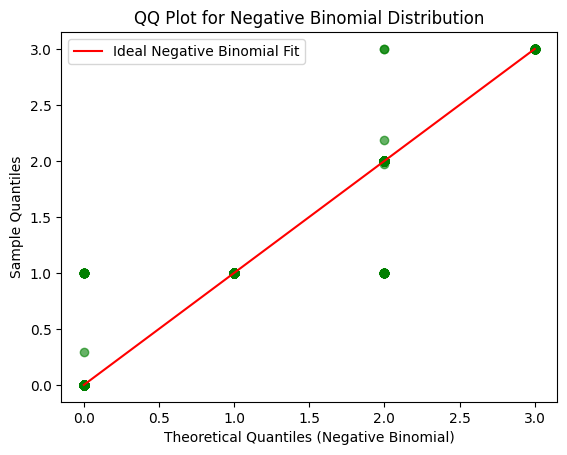

In [39]:
# 负二项分布参数估计（方法矩估计）
if nb_var > nb_mean:  # 负二项分布要求 方差 > 均值
    nb_r = (nb_mean ** 2) / (nb_var - nb_mean)
    nb_p = nb_mean / nb_var
else:
    print("方差小于均值，不适合使用负二项分布")

# 计算负二项理论分位数
nb_quantiles = stats.nbinom.ppf(np.linspace(0.01, 0.99, len(malat1_counts)), n=nb_r, p=nb_p)
sample_quantiles = np.percentile(malat1_counts, np.linspace(1, 99, len(malat1_counts)))

# 绘制负二项 QQ 图
plt.scatter(nb_quantiles, sample_quantiles, color="green", alpha=0.6)
plt.plot(nb_quantiles, nb_quantiles, "r-", label="Ideal Negative Binomial Fit")
plt.xlabel("Theoretical Quantiles (Negative Binomial)")
plt.ylabel("Sample Quantiles")
plt.title("QQ Plot for Negative Binomial Distribution")
plt.legend()
plt.show()


In [41]:
from scipy.stats import kstest

# KS 检验，测试样本数据是否来自 NB 分布
ks_stat, ks_p_value = kstest(malat1_counts, 'nbinom', args=(nb_r, nb_p))
print(f"KS 统计量: {ks_stat:.4f}, P 值: {ks_p_value:.4f}")

if ks_p_value > 0.05:
    print("负二项分布拟合较好")
else:
    print("负二项分布拟合不佳，可能需要 ZINB")


KS 统计量: 0.6326, P 值: 0.0000
负二项分布拟合不佳，可能需要 ZINB


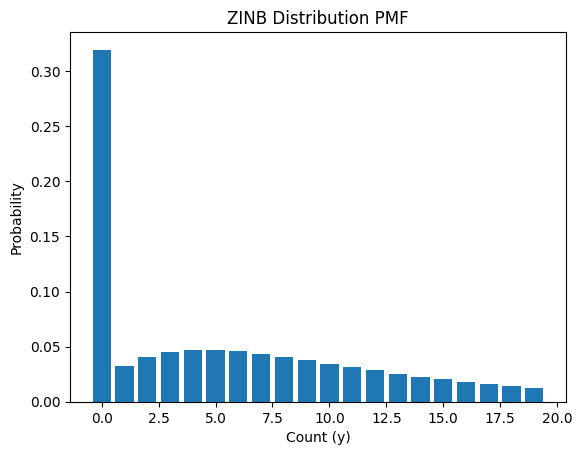

In [7]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# ZINB分布的概率质量函数
def zinb_pmf(y, mu, alpha, pi):
    """
    计算ZINB分布的概率质量函数(PMF)
    
    参数:
    y -- 观察到的计数值
    mu -- 负二项分布的均值
    alpha -- 负二项分布的形状参数
    pi -- 零膨胀概率
    
    返回:
    P(Y = y) -- ZINB分布的概率
    """
    if y == 0:
        return pi + (1 - pi) * stats.nbinom.pmf(y, alpha, alpha / (mu + alpha))
    else:
        return (1 - pi) * stats.nbinom.pmf(y, alpha, alpha / (mu + alpha))

# 参数设置
mu = 10  # 均值
alpha = 2  # 形状参数
pi = 0.3  # 零膨胀概率

# 生成一些ZINB分布数据
y_values = np.arange(0, 20)
pmf_values = [zinb_pmf(y, mu, alpha, pi) for y in y_values]

# 绘制PMF
plt.bar(y_values, pmf_values)
plt.xlabel('Count (y)')
plt.ylabel('Probability')
plt.title('ZINB Distribution PMF')
plt.show()


In [ ]:
import numpy as np
import scipy.stats as stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# 假设你的数据是这样的
data = np.random.poisson(10, 10000)  # 这里使用Poisson数据作为示例
# data = gene_counts_distribution 

# ZINB分布的概率质量函数
def zinb_pmf(y, mu, alpha, pi):
    if y == 0:
        return pi + (1 - pi) * stats.nbinom.pmf(y, alpha, alpha / (mu + alpha))
    else:
        return (1 - pi) * stats.nbinom.pmf(y, alpha, alpha / (mu + alpha))

# 计算负二项分布的负对数似然函数
def negative_log_likelihood(params, data):
    mu, alpha, pi = params
    if mu <= 0 or alpha <= 0 or not (0 <= pi <= 1):  # 参数约束
        return np.inf
    
    log_likelihood = 0
    for y in data:
        log_likelihood += np.log(zinb_pmf(y, mu, alpha, pi))
    
    return -log_likelihood  # 负对数似然

# 使用最优化方法拟合ZINB参数
initial_params = [10, 1, 0.2]  # 初始参数猜测 (mu, alpha, pi)
result = minimize(negative_log_likelihood, initial_params, args=(data,), bounds=[(0, None), (0, None), (0, 1)])

# 获取拟合后的参数
mu_fit, alpha_fit, pi_fit = result.x
print(f"拟合参数：mu = {mu_fit}, alpha = {alpha_fit}, pi = {pi_fit}")
